<a href="https://colab.research.google.com/github/healthonrails/annolid/blob/main/docs/tutorials/Annolid_on_Detectron2_Tutorial.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Annolid on Detectron2 Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to Annolid on detectron2! This is modified from the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [2]:
# Is running in colab or in jupyter-notebook
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
# install dependencies: 
!pip install pyyaml==5.3
import torch, torchvision
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.10 ; cuda:  cu102
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html


In [4]:
# import some common libraries
import json
import os
import cv2
import random
import glob
import numpy as np
if IN_COLAB:
  from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


In [6]:
# is there a gpu
if torch.cuda.is_available():
    GPU = True
    print('gpu available')
else:
    GPU = False
    print('no gpu')

no gpu


## Upload a labeled dataset.
The following code is expecting the dataset in the COCO format to be in a ***.zip*** file. For example here we are going to use the example dataset we provide that is named ```novelctrlk6_8_coco_dataset.zip``` \
Note: please make sure there is no white space in your file path if you encounter file not found issues.

In [7]:
!pip install gdown
!gdown --id 1fUXCLnoJ5SwXg54mj0NBKGzidsV8ALVR

Downloading...
From: https://drive.google.com/uc?id=1fUXCLnoJ5SwXg54mj0NBKGzidsV8ALVR
To: /mnt/home_nas/jeremy/Recherches/Postdoc/CPLab/Projects/Annolid/annolid/book/tutorials/novelctrlk6_8_coco_dataset.zip
100%|██████████████████████████████████████| 10.3M/10.3M [00:00<00:00, 13.2MB/s]


In [8]:
if IN_COLAB:
    dataset = 'content/novelctrlk6_8_coco_dataset.zip'
else:
    dataset = 'novelctrlk6_8_coco_dataset.zip'

In [9]:
if IN_COLAB:
    !unzip $dataset -d /content/
else:
    #TODO generalize this
    !unzip -o $dataset -d .

Archive:  novelctrlk6_8_coco_dataset.zip
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00001416_41.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004233_81.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004515_22.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000636_6.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006297_11.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006818_79.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006056_25.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006094_12.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004340_96.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000557_50.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000979_94.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00005018_19.jpg  
  inflating: ./novelctrlk6_8_coco_da

  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000952_60.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00000842_70.jpg  
  inflating: ./__MACOSX/novelctrlk6_8_coco_dataset/train/JPEGImages/._00000842_70.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00002295_32.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004117_59.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003976_44.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004032_20.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006212_69.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00003134_31.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006169_98.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00006830_36.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/00004570_24.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/train/JPEGImages/000007

In [10]:
DATASET_NAME = DATASET_DIR = f"{dataset.replace('.zip','')}"

# Run a pre-trained detectron2 model

First, we check a random selected image from our training dataset:

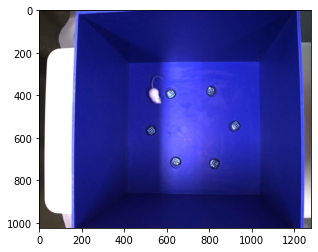

In [11]:
# select and display one random image from the training set
img_file = random.choice(glob.glob(f"{DATASET_DIR}/train/JPEGImages/*.*"))
im = cv2.imread(img_file)
if IN_COLAB:
    cv2_imshow(im)
else:
    plt.imshow(im)

Then, we create a Detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [12]:
cfg = get_cfg()

In [13]:
if GPU:
    pass
else:
    cfg.MODEL.DEVICE='cpu'

In [14]:
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set threshold for this model
# Find a model from Detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/home/jeremy/anaconda3/envs/annolid/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/jeremy/anaconda3/envs/annolid/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [15]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 6, 65, 74, 74, 56])
Boxes(tensor([[  75.6154,   37.8977, 1273.1077,  985.7012],
        [  18.1820,  134.1059,  163.1887,  981.1087],
        [ 898.1162,  518.6722,  948.0486,  567.4241],
        [ 504.1673,  541.2513,  551.8248,  588.9865],
        [   0.0000,   35.3450,  163.4191, 1012.4688]]))


In [16]:
outputs['instances'].pred_masks

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [17]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

namespace(name='coco_2017_train',
          json_file='datasets/coco/annotations/instances_train2017.json',
          image_root='datasets/coco/train2017',
          evaluator_type='coco',
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5,
                                             7: 6,
                                             8: 7,
                                             9: 8,
                                             10: 9,
                                             11: 10,
                                             13: 11,
                                             14: 12,
                                             15: 13,
                                             16: 14,
                                   

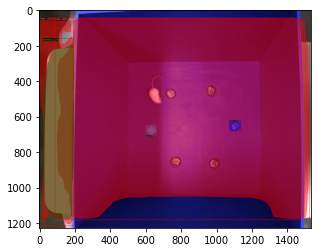

In [18]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
if IN_COLAB:
    cv2_imshow(out.get_image()[:, :, ::-1])
else:
    plt.imshow(out.get_image()[:, :, ::-1])

As we can see, the network doesn't detect what we want. That is expected as we have not fine-tuned the network with our custom dataset. We are going to do that in the next steps.

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in COCO format.

## Prepare the dataset

Register the custom dataset to Detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in COCO format, therefore we register  into Detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [19]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import get_detection_dataset_dicts
from detectron2.data.datasets import  builtin_meta

In [20]:
register_coco_instances(f"{DATASET_NAME}_train", {}, f"{DATASET_DIR}/train/annotations.json", f"{DATASET_DIR}/train/")
register_coco_instances(f"{DATASET_NAME}_valid", {}, f"{DATASET_DIR}/valid/annotations.json", f"{DATASET_DIR}/valid/")

In [21]:
dataset_dicts = get_detection_dataset_dicts([f"{DATASET_NAME}_train"])

[01/21 05:30:27 d2.data.datasets.coco]: Loaded 118 images in COCO format from novelctrlk6_8_coco_dataset/train/annotations.json
[01/21 05:30:27 d2.data.build]: Removed 0 images with no usable annotations. 118 images left.
[01/21 05:30:27 d2.data.build]: Distribution of instances among all 7 categories:
|   category   | #instances   |  category  | #instances   |  category  | #instances   |
|:------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| _background_ | 0            |    nose    | 118          |  left_ear  | 118          |
|  right_ear   | 117          | tail_base  | 119          |   mouse    | 118          |
|   centroid   | 1            |            |              |            |              |
|    total     | 591          |            |              |            |              |


In [22]:
_dataset_metadata = MetadataCatalog.get(f"{DATASET_NAME}_train")
_dataset_metadata.thing_colors = [cc['color'] for cc in builtin_meta.COCO_CATEGORIES]

In [23]:
_dataset_metadata

namespace(name='novelctrlk6_8_coco_dataset_train',
          json_file='novelctrlk6_8_coco_dataset/train/annotations.json',
          image_root='novelctrlk6_8_coco_dataset/train/',
          evaluator_type='coco',
          thing_classes=['_background_',
                         'nose',
                         'left_ear',
                         'right_ear',
                         'tail_base',
                         'mouse',
                         'centroid'],
          thing_dataset_id_to_contiguous_id={0: 0,
                                             1: 1,
                                             2: 2,
                                             3: 3,
                                             4: 4,
                                             5: 5,
                                             6: 6},
          thing_colors=[[220, 20, 60],
                        [119, 11, 32],
                        [0, 0, 142],
                        [0, 0, 230],
                

In [24]:
NUM_CLASSES = len(_dataset_metadata.thing_classes)
print(f"{NUM_CLASSES} Number of classes in the dataset")

7 Number of classes in the dataset


To verify the data loading is correct, let's visualize the annotations of a randomly selected sample in the training set:



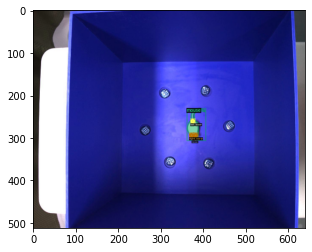

In [25]:
for d in random.sample(dataset_dicts, 2):
    if '\\' in d['file_name']:
        d['file_name'] = d['file_name'].replace('\\','/')
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=_dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    if IN_COLAB:
        cv2_imshow(out.get_image()[:, :, ::-1])
    else:
        plt.imshow(out.get_image()[:, :, ::-1])
        

## Train!

Now, let's fine-tune the COCO-pretrained R50-FPN Mask R-CNN model with our custom dataset. It takes ~2 hours to train 3000 iterations on Colab's K80 GPU, or ~1.5 hours on a P100 GPU.


In [26]:
if GPU:
    !nvidia-smi

In [27]:
from detectron2.engine import DefaultTrainer

In [28]:
cfg = get_cfg()

In [29]:
if GPU:
    pass
else:
    cfg.MODEL.DEVICE='cpu'

In [30]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2 #@param
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD = 0.3
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH =  8 #@param
cfg.SOLVER.BASE_LR = 0.0025 #@param # pick a good LR
cfg.SOLVER.MAX_ITER = 3000 #@param    # 300 iterations seems good enough for 100 frames dataset; you will need to train longer for a practical dataset
cfg.SOLVER.CHECKPOINT_PERIOD = 1000 #@param 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 #@param   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES  #  (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)


[01/21 05:30:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[01/21 05:30:28 d2.data.datasets.coco]: Loaded 118 images in COCO format from novelctrlk6_8_coco_dataset/train/annotations.json
[01/21 05:30:28 d2.data.build]: Removed 0 images with no usable annotations. 118 images left.
[01/21 05:30:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/21 05:30:28 d2.data.build]: Using training sampler RepeatFactorTrainingSampler
[01/21 05:30:28 d2.data.common]: Serializing 118 elements to byte tensors and concatenating them all ...
[01/21 05:30:28 d2.data.common]: Serialized dataset takes 0.31 MiB
WARNING [01/21 05:30:28 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (7, 256, 1, 1) 

In [31]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
trainer.train()

[01/21 05:30:32 d2.engine.train_loop]: Starting training from iteration 0


/home/jeremy/anaconda3/envs/annolid/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[01/21 05:45:21 d2.utils.events]:  eta: 1 day, 11:17:38  iter: 19  total_loss: 5.468  loss_cls: 2.148  loss_box_reg: 0.5272  loss_mask: 0.6881  loss_rpn_cls: 1.72  loss_rpn_loc: 0.3729  time: 43.2125  data_time: 0.9429  lr: 4.9952e-05  
[01/21 06:00:07 d2.utils.events]:  eta: 1 day, 11:08:08  iter: 39  total_loss: 3.097  loss_cls: 1.367  loss_box_reg: 0.7502  loss_mask: 0.6692  loss_rpn_cls: 0.0581  loss_rpn_loc: 0.2386  time: 43.7766  data_time: 0.1620  lr: 9.9902e-05  
[01/21 06:15:11 d2.utils.events]:  eta: 1 day, 11:23:44  iter: 59  total_loss: 2.656  loss_cls: 0.9361  loss_box_reg: 0.8174  loss_mask: 0.6501  loss_rpn_cls: 0.04557  loss_rpn_loc: 0.2009  time: 44.2544  data_time: 0.3378  lr: 0.00014985  
[01/21 06:30:06 d2.utils.events]:  eta: 1 day, 11:36:27  iter: 79  total_loss: 2.546  loss_cls: 0.8501  loss_box_reg: 0.8529  loss_mask: 0.6259  loss_rpn_cls: 0.03656  loss_rpn_loc: 0.171  time: 44.3795  data_time: 0.2600  lr: 0.0001998  
[01/21 06:45:25 d2.utils.events]:  eta: 1 da

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. 
# We simply update the weights with the newly trained ones to perform inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# set a custom testing threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15   #@param {type: "slider", min:0.0, max:1.0, step: 0.01}
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

In [ ]:
dataset_dicts = get_detection_dataset_dicts([f"{DATASET_NAME}_valid"])
for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=_dataset_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    if IN_COLAB:
        cv2_imshow(out.get_image()[:, :, ::-1])
    else:
        plt.imshow(out.get_image()[:, :, ::-1])
        plt.show()
        

A more robust way to evaluate the model is to use a metric called Average Precision (AP) already implemented in the detectron2 package. If you want more precision on what the AP is, you can take a look [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) and [here](https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision). 

### #TODO: expand on  how to interpret AP

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [ ]:
if IN_COLAB:
    evaluator = COCOEvaluator(f"{DATASET_NAME}_valid", cfg, False, output_dir="/content/eval_output/")
else:
    evaluator = COCOEvaluator(f"{DATASET_NAME}_valid", cfg, False, output_dir="eval_output/")

val_loader = build_detection_test_loader(cfg, f"{DATASET_NAME}_valid")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

# Let's test our newly trained mode on a new video

## We download a video from a URL

In [ ]:
#e.g.
#!wget https://hosting-website.com/your-video.mp4

### Please change the VIDEO_INPUT to the path of your inference video

In [ ]:
VIDEO_INPUT="/content/video60.mkv"
OUTPUT_DIR = "/content/eval_output"

In [ ]:
VIDEO_INPUT = '../../sample_dataset/sample_video.mp4'
OUTPUT_DIR = "../../sample_dataset/"

In [ ]:
import cv2

In [ ]:
video = cv2.VideoCapture(VIDEO_INPUT)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
basename = os.path.basename(VIDEO_INPUT)

In [ ]:
import os 
os.makedirs(OUTPUT_DIR,exist_ok=True)

In [ ]:
def _frame_from_video(video):
  attempt = 0
  for i in range(num_frames):
      success, frame = video.read()
      if success:
          yield frame
      else:
          attempt += 1
          if attempt >= 2000:
              break
          else:
              video.set(cv2.CAP_PROP_POS_FRAMES, i+1)
              print('Cannot read this frame:', i)
              continue

In [ ]:
import pandas as pd
import pycocotools.mask as mask_util

In [ ]:
class_names = _dataset_metadata.thing_classes
print(class_names)

In [ ]:
frame_number = 0
tracking_results = []
VIS = True
for frame in _frame_from_video(video): 
    im = frame
    outputs = predictor(im)
    out_dict = {}  
    instances = outputs["instances"].to("cpu")
    num_instance = len(instances)
    if num_instance == 0:
        out_dict['frame_number'] = frame_number
        out_dict['x1'] = None
        out_dict['y1'] = None
        out_dict['x2'] = None
        out_dict['y2'] = None
        out_dict['instance_name'] = None
        out_dict['class_score'] = None
        out_dict['segmentation'] = None
        tracking_results.append(out_dict)
        out_dict = {}
    else:
        boxes = instances.pred_boxes.tensor.numpy()
        boxes = boxes.tolist()
        scores = instances.scores.tolist()
        classes = instances.pred_classes.tolist()

        has_mask = instances.has("pred_masks")

        if has_mask:
            rles =[
                   mask_util.encode(np.array(mask[:,:,None], order="F", dtype="uint8"))[0]
                   for mask in instances.pred_masks
            ]
            for rle in rles:
              rle["counts"] = rle["counts"].decode("utf-8")

        assert len(rles) == len(boxes)
        for k in range(num_instance):
            box = boxes[k]
            out_dict['frame_number'] = frame_number
            out_dict['x1'] = box[0]
            out_dict['y1'] = box[1]
            out_dict['x2'] = box[2]
            out_dict['y2'] = box[3]
            out_dict['instance_name'] = class_names[classes[k]]
            out_dict['class_score'] = scores[k]
            out_dict['segmentation'] = rles[k]
            if frame_number % 1000 == 0:
              print(f"Frame number {frame_number}: {out_dict}")
            tracking_results.append(out_dict)
            out_dict = {}
        
    # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    if VIS:
        v = Visualizer(im[:, :, ::-1],
                    metadata=_dataset_metadata, 
                    scale=0.5, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
         )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_image = out.get_image()[:, :, ::-1]
        if frame_number % 1000 == 0:
            if IN_COLAB:
                cv2_imshow(out_image)
            else:
                plt.imshow(out_image)
                plt.show()
            #Trun off the visulization to save time after the first frame
            VIS = False
    frame_number += 1
    print(f"Processing frame number {frame_number}")

video.release()

## All the tracking results will be saved to this Pandas dataframe. 



In [ ]:
df = pd.DataFrame(tracking_results)

In [ ]:
df.head()

## Calculate the bbox center point x, y locations

In [ ]:
cx = (df.x1 + df.x2)/2
cy = (df.y1 + df.y2)/2
df['cx'] = cx
df['cy'] = cy

In [ ]:
df.head()

## Only save the top 1 prediction for each frame for each class
Note: You can change the number to save top n predictions for each frame and an instance name. head(2), head(5), or head(n)
To save all the predictions, please use `df.to_csv('my_tracking_results.csv')`.

In [ ]:
df_top = df.groupby(['frame_number','instance_name'],sort=False).head(1)

In [ ]:
df_top.head()

## Visualize the center points with plotly scatter plot

In [ ]:
df_vis = df_top[df_top.instance_name != 'Text'][['frame_number','cx','cy','instance_name']]

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

fig = px.scatter(df_vis, 
                 x="cx",
                 y="cy", 
                 color="instance_name",
                 hover_data=['frame_number','cx','cy'])
fig.show()

In [ ]:
from pathlib import  Path
tracking_results_csv = f"{Path(dataset).stem}_{Path(VIDEO_INPUT).stem}_{cfg.SOLVER.MAX_ITER}_iters_mask_rcnn_tracking_results_with_segmenation.csv"
df_top.to_csv(tracking_results_csv)

## Download the tracking result CSV file to your local device

In [ ]:
if IN_COLAB:
    from google.colab import files
    files.download(tracking_results_csv)

# The following sections are optional. 

## Caculate the distance of a pair of instances in a given frame

In [ ]:
def paired_distance(frame_number,
                    this_instance='frog_m_2',
                    other_instance='frog_f_2'):
    df_dis = df_top[df_top["frame_number"]==frame_number][['cx','cy','instance_name']]
    df_this = df_dis[df_dis.instance_name == this_instance]
    df_other = df_dis[df_dis.instance_name == other_instance]
    try:
      dist = np.linalg.norm(df_this[['cx','cy']].values-df_other[['cx','cy']].values)
    except:
      dist = None


    return dist

## Calculate the distance of the instance from the current and previous frame

In [ ]:
def instance_distance_between_frame(frame_number,
                                    instance_name='frog_m_1'):
    if frame_number < 1:
      return 0
    previous_frame_number = frame_number - 1
    df_dis = df_top[df_top["frame_number"]==frame_number][['cx','cy','instance_name']]
    df_dis_prev = df_top[df_top["frame_number"]==previous_frame_number][['cx','cy','instance_name']]
    df_dis = df_dis[df_dis.instance_name == instance_name]
    df_dis_prev = df_dis_prev[df_dis_prev.instance_name == instance_name]

    try:
      dist = np.linalg.norm(df_dis[['cx','cy']].values-df_dis_prev[['cx','cy']].values)
    except:
      dist = None
    
    return dist
    

In [ ]:
df_top['dist_from_previous_frame_frog_m_1'] = df_top.frame_number.apply(instance_distance_between_frame)

## The total distance traveled for frog male in Tank 1 in pixels

In [ ]:
df_top['dist_from_previous_frame_frog_m_1'].sum()


In [ ]:

fig = px.line(x=df_top.frame_number, y=df_top.dist_from_previous_frame_frog_m_1, labels={'x':'frame_number', 'y':'distance from previous frame frog_m_1'})
fig.show()

## Download and save the results to your local device

### Please change the desired CSV file name

In [ ]:
tracking_results_with_area_perimeter_csv = f"{tracking_results_csv.replace('.csv','_final.csv')}"
df_top.to_csv(tracking_results_with_area_perimeter_csv)
files.download(tracking_results_with_area_perimeter_csv)

## Distance between frog male in tank 2 and frog female in tank 2 in pixels

In [ ]:
df_top['dist_frog_m2_f2'] = df_top.frame_number.apply(paired_distance)

In [ ]:

fig = px.line(x=df_top.frame_number, y=df_top.dist_frog_m2_f2, labels={'x':'frame_number', 'y':'distance between frog male in tank 2 to frog female in tank 2'})
fig.show()

## Save and download the trained model weights

In [ ]:
final_model_file = os.path.join(cfg.OUTPUT_DIR,'model_final.pth')
files.download(final_model_file)